In [76]:
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Define feature generation
def add_features(data):
    """Create additional technical indicators and prediction target while keeping alignment intact"""
    df = data.copy()

    # Technical indicators
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Close'].pct_change().rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['Return'] = df['Close'].pct_change()

    # Feature engineering
    df['X_MA5'] = (df['Close'] - df['MA5']) / df['Close']
    df['X_MA10'] = (df['Close'] - df['MA10']) / df['Close']
    df['X_MA20'] = (df['Close'] - df['MA20']) / df['Close']
    df['X_MA5_10'] = (df['MA5'] - df['MA10']) / df['Close']
    df['X_MA10_20'] = (df['MA10'] - df['MA20']) / df['Close']
    df['X_Volatility'] = df['Volatility']
    df['X_Momentum'] = df['Momentum']
    df['X_Return'] = df['Return']
    df['X_Return_5'] = df['Return'].rolling(5).sum()
    df['X_VOL_CHG'] = df['Volume'].pct_change(5)

    # Target: use binary or multi-class depending on your setup
    df['Target'] = np.where(df['Return'].shift(-1) > 0.005, 2,
                    np.where(df['Return'].shift(-1) < -0.005, 0, 1))

    return df  # ❗ Keep full index, no dropna()


In [77]:
class XGBoostStrategy(Strategy):
    n_estimators = 100
    max_depth = 5
    learning_rate = 0.1
    train_size = 500
    price_delta = 0.01  # take-profit and stop-loss % (1%)
    
    def init(self):
        # Load data with features
        full_df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')
        
        # Align with backtesting data
        self.all_data = full_df
        
        # Precompute features and mapping
        self.X_all = get_X(self.all_data)
        self.y_all = get_y(self.all_data)
        self.feature_index = {i: i for i in range(len(self.all_data))}
        
        # For visualization
        self.pred = self.I(lambda: np.zeros(len(self.data)), name='prediction')
        
        # Train XGBoost model once
        self.model = XGBClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            use_label_encoder=False,
            eval_metric='mlogloss',  # For multiclass prediction
            random_state=42
        )
        
        # Use only bars with enough data
        if len(self.X_all) >= self.train_size:
            X_train = self.X_all[:self.train_size]
            y_train = self.y_all[:self.train_size]
            self.model.fit(X_train, y_train)
            
        self.predictions = []
        self.actuals = []
    
    def next(self):
        i = len(self.data) - 1
        
        # Skip if we don't have enough data
        if i >= len(self.X_all):
            return
        
        features = self.X_all[i].reshape(1, -1)
        
        # Get prediction and confidence
        try:
            pred_class = self.model.predict(features)[0]  # This is 0, 1, or 2
            confidence = max(self.model.predict_proba(features)[0])
        except:
            return
        
        # For visualization
        self.pred[-1] = pred_class
        
        close = self.data.Close[-1]
        size = min(0.5, confidence * 0.5)
        
        tp_long = close * (1 + self.price_delta)
        sl_long = close * (1 - self.price_delta)
        tp_short = close * (1 - self.price_delta)
        sl_short = close * (1 + self.price_delta)
        
        # Record prediction and actual for later evaluation
        try:
            y_true = self.y_all[i]
            self.predictions.append(pred_class)
            self.actuals.append(int(y_true))
        except:
            pass
        
        # Execute trade based on prediction
        if pred_class == 2 and not self.position.is_long:  # Bullish
            if self.position.is_short:
                self.position.close()
            self.buy(size=size, tp=tp_long, sl=sl_long)
            
        elif pred_class == 0 and not self.position.is_short:  # Bearish
            if self.position.is_long:
                self.position.close()
            self.sell(size=size, tp=tp_short, sl=sl_short)
            
        elif pred_class == 1:  # Neutral
            if confidence > 0.75 and (self.position.is_long or self.position.is_short):
                self.position.close()

In [78]:
bt = Backtest(df, XGBoostStrategy, cash=10_000, commission=.0002)
backtest = bt.run()
backtest

/var/folders/qj/c7654q5s2zb76938lp4d13y80000gn/T/ipykernel_14821/443056425.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:24:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest.run:   0%|          | 0/986 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:955: UserWarning: time=2: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:955: UserWarning: time=3: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:955: UserWarning: time=6: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:955: UserWarning: time=7: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:955: UserWarning: time=9: Broker canceled the relative-sized order due to insufficient margin.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/backtesting/backtesting.py:955: UserWarni

Start                     2020-01-30 00:00:00
End                       2023-12-29 00:00:00
Duration                   1429 days 00:00:00
Exposure Time [%]                    44.68085
Equity Final [$]                  13326.89421
Equity Peak [$]                   14062.19283
Commissions [$]                     536.36446
Return [%]                           33.26894
Buy & Hold Return [%]                45.25956
Return (Ann.) [%]                     7.60828
Volatility (Ann.) [%]                 2.37326
CAGR [%]                              5.19512
Sharpe Ratio                          3.20584
Sortino Ratio                         5.80837
Calmar Ratio                          0.92546
Alpha [%]                            32.96287
Beta                                  0.00676
Max. Drawdown [%]                    -8.22111
Avg. Drawdown [%]                    -0.35433
Max. Drawdown Duration      686 days 00:00:00
Avg. Drawdown Duration       28 days 00:00:00
# Trades                          

In [79]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_strategy(y_true, y_pred):

    print("Evaluation Metrics")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision (macro):", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (0)', 'Neutral (1)', 'Up (2)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
bt.plot()

Evaluation Metrics
Accuracy: 0.6917
Precision (macro): 0.6801
F1 Score (macro): 0.6817


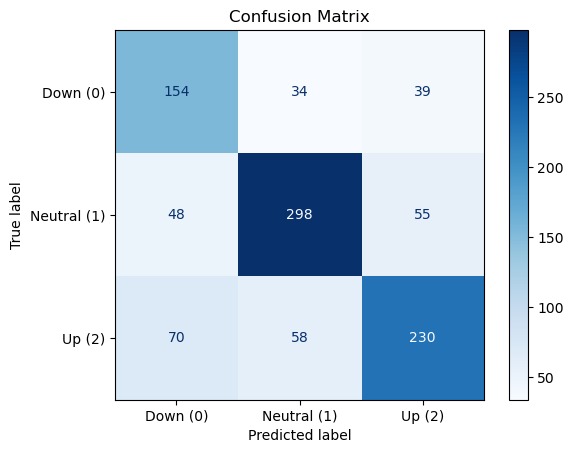

In [80]:
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)